In [1]:
!wget http://supermoe.cs.umass.edu/shape_recog/shaded_images.tar.gz
!tar xvzf shaded_images.tar.gz
!pip install tensorboardX

Streaming output truncated to the last 5000 lines.
modelnet40_images_new_12x/curtain/train/curtain_0001.obj.shaded_v006.png
modelnet40_images_new_12x/curtain/train/curtain_0129.obj.shaded_v001.png
modelnet40_images_new_12x/curtain/train/curtain_0003.obj.shaded_v007.png
modelnet40_images_new_12x/curtain/train/curtain_0038.obj.shaded_v004.png
modelnet40_images_new_12x/curtain/train/curtain_0096.obj.shaded_v010.png
modelnet40_images_new_12x/curtain/train/curtain_0025.obj.shaded_v004.png
modelnet40_images_new_12x/curtain/train/curtain_0004.obj.shaded_v012.png
modelnet40_images_new_12x/curtain/train/curtain_0077.obj.shaded_v010.png
modelnet40_images_new_12x/curtain/train/curtain_0020.obj.shaded_v011.png
modelnet40_images_new_12x/curtain/train/curtain_0098.obj.shaded_v004.png
modelnet40_images_new_12x/curtain/train/curtain_0128.obj.shaded_v003.png
modelnet40_images_new_12x/curtain/train/curtain_0130.obj.shaded_v001.png
modelnet40_images_new_12x/curtain/train/curtain_0103.obj.shaded_v008.png


In [2]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import os
import math
import glob
import time
import random
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as vision
from torchvision import transforms, datasets
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt

from skimage import io, transform
from PIL import Image

In [4]:
def get_categories(root_dir):
    list_dir = sorted(os.listdir(root_dir))
    list_dir = [dir for dir in list_dir if os.path.isdir(os.path.join(root_dir, dir))]
    classes = {folder: i for i, folder in enumerate(list_dir)}
    return classes

class SingleImgDataset:
    def __init__(self, root_dir, folder="train", num_models=12000, num_views=12):
        self.root_dir = root_dir
        # self.classnames = list(get_categories(self.root_dir).keys())
        self.classnames = ['bathtub','bed','chair', 'desk','dresser', 'monitor','night_stand','sofa','table','toilet']
        self.filepaths = []
        for i in range(len(self.classnames)):
            fn = os.path.join(root_dir, self.classnames[i], folder, "*shaded*.png")
            all_files = sorted(glob.glob(fn))
            self.filepaths.extend(all_files[:min(num_models,len(all_files))])
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
        ])

    def __getitem__(self, idx):
        fn = self.filepaths[idx]
        class_id = self.classnames.index(fn.split('/')[-3])
        im = Image.open(self.filepaths[idx]).convert('RGB') 
        im = self.transform(im)
        return (class_id, im, fn)

    def __len__(self):
        return len(self.filepaths)

class MultiviewImgDataset:
    def __init__(self, root_dir, folder="train", num_models=12000, num_views=12):
        self.root_dir = root_dir
        self.num_views = num_views
        self.classnames = ['bathtub','bed','chair', 'desk','dresser', 'monitor','night_stand','sofa','table','toilet']

        self.filepaths = []
        for i in range(len(self.classnames)):
            fn = os.path.join(root_dir, self.classnames[i], folder, "*.png")
            all_files = sorted(glob.glob(fn))
            # all_files = all_files[::1]
            self.filepaths.extend(all_files[:min(num_models,len(all_files))])

        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return int(len(self.filepaths)/self.num_views)

    def __getitem__(self, idx):
        path = self.filepaths[idx*self.num_views]
        class_id = self.classnames.index(path.split('/')[-3])
        imgs = []
        for i in range(self.num_views):
            im = Image.open(self.filepaths[idx*self.num_views+i]).convert('RGB')
            if self.transform:
                im = self.transform(im)
            imgs.append(im)
        return (class_id, torch.stack(imgs), self.filepaths[idx*self.num_views:(idx+1)*self.num_views])


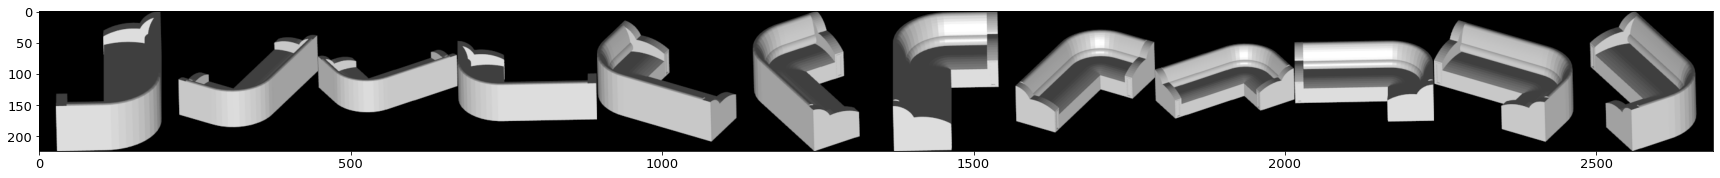

In [62]:
path = "modelnet40_images_new_12x"
train_dataset = MultiviewImgDataset(path, folder="train", num_models=12000, num_views=12)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

for i, data in enumerate(train_loader):
    row = [data[1][0][i] for i in range(12)]
    break
plt.figure(figsize=(30, 360))
plt.imshow(torch.cat(row, 2).permute(1,2,0))
plt.show()

In [16]:
def toVariable(data, model_name):
    if model_name == 'mvcnn':
        _,_,C,H,W = data.size()
        input = Variable(data).view(-1,C,H,W).cuda()
    elif model_name == 'svcnn': #'svcnn'
        input = Variable(data).cuda()
    return input
        
def train(model, model_name, train_loader, val_loader, optimizer, loss_fn, n_epochs):
    model.cuda()
    model.train()

    hist = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
    for epoch in range(n_epochs):

        tmp_loss = 0
        total_correct = 0
        total_res = 0
        for i, (label, data, fn) in enumerate(train_loader):
            input = toVariable(data, model_name)
            target = Variable(label).cuda().long()

            optimizer.zero_grad()
            output = model(input)
            loss = loss_fn(output, target)
            pred = torch.max(output, 1)[1]
            results = (pred == target)

            correct = torch.sum(results.long())
            total_correct += correct
            acc = correct.float()/results.size()[0]
            total_res += results.size()[0]
            loss.backward()
            optimizer.step()
            
            if (i+1)%1==0:
                print('epoch %d, step %d: train_loss %.3f; train_acc %.3f' % (epoch+1, i+1, loss, acc))
                tmp_loss += loss

        hist["loss"].append(tmp_loss/len(train_loader))
        hist["acc"].append(total_correct/total_res)
        print("loss", tmp_loss/len(train_loader))
        print("acc", total_correct/total_res)
        if (epoch+1)%1==0:
            with torch.no_grad():
                loss, val_overall_acc, val_mean_class_acc = update_validation_accuracy(model, model_name, val_loader, optimizer, loss_fn)

            file = open("./drive/My Drive/mvcnn_models/logs-" + model_name + ".txt","a") 
            file.write('epoch:{}\t loss:{}\t val_overall_acc:{}\t val_mean_class_acc:{}\n'.format(epoch+1, loss, val_overall_acc, val_mean_class_acc)) 
            file.close()

            hist["val_loss"].append(loss)
            hist["val_acc"].append(val_overall_acc)

        # adjust learning rate manually
        if epoch > 0 and (epoch+1) % 10 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr']*0.5

        torch.save(model.state_dict(), "./drive/My Drive/mvcnn_models/" + model_name + "_"+str(epoch)+".pth")
    print(hist)

def update_validation_accuracy(model, model_name, val_loader, optimizer, loss_fn):
    all_correct_points, all_points = 0, 0
    wrong_class, samples_class = np.zeros(10), np.zeros(10)
    all_loss = 0
    model.eval()

    for _, (label, data, fn) in enumerate(val_loader, 0):
        input = toVariable(data, model_name)

        target = Variable(label).cuda()
        output = model(input)
        pred = torch.max(output, 1)[1]
        all_loss += loss_fn(output, target).cpu().data.numpy()
        results = (pred == target)

        for i in range(results.size()[0]):
            if not bool(results[i].cpu().data.numpy()):
                wrong_class[target.cpu().data.numpy().astype('int')[i]] += 1
            samples_class[target.cpu().data.numpy().astype('int')[i]] += 1

        all_correct_points += torch.sum(results.long())
        all_points += results.size()[0]

    print('Total # of test models: ', all_points)
    val_mean_class_acc = np.mean((samples_class-wrong_class)/samples_class)
    acc = all_correct_points.float() / all_points
    val_overall_acc = acc.cpu().data.numpy()
    loss = all_loss / len(val_loader)

    print('val mean class acc. : ', val_mean_class_acc)
    print('val overall acc. : ', val_overall_acc)
    print('val loss : ', loss)

    model.train()
    return loss, val_overall_acc, val_mean_class_acc

In [8]:
class SVCNN(nn.Module):
    def __init__(self, num_classes=10, pretraining=True, cnn_name='vgg11'):
        super(SVCNN, self).__init__()
        self.num_classes = num_classes
        self.pretraining = pretraining
        self.cnn_name = cnn_name

        if self.cnn_name.startswith('resnet'):
            if self.cnn_name == 'resnet18':
                self.net = models.resnet18(pretrained=self.pretraining)
                self.net.fc = nn.Linear(512,self.num_classes)
            elif self.cnn_name == 'resnet34':
                self.net = models.resnet34(pretrained=self.pretraining)
                self.net.fc = nn.Linear(512,self.num_classes)
            elif self.cnn_name == 'resnet50':
                self.net = models.resnet50(pretrained=self.pretraining)
                self.net.fc = nn.Linear(2048,self.num_classes)
        else:
            if self.cnn_name == 'alexnet':
                self.net_1 = models.alexnet(pretrained=self.pretraining).features
                self.net_2 = models.alexnet(pretrained=self.pretraining).classifier
            elif self.cnn_name == 'vgg11':
                self.net_1 = models.vgg11(pretrained=self.pretraining).features
                self.net_2 = models.vgg11(pretrained=self.pretraining).classifier
            elif self.cnn_name == 'vgg16':
                self.net_1 = models.vgg16(pretrained=self.pretraining).features
                self.net_2 = models.vgg16(pretrained=self.pretraining).classifier
            
            self.net_2._modules['6'] = nn.Linear(4096,self.num_classes)

    def forward(self, x):
        if self.cnn_name.startswith('resnet'):
            return self.net(x)
        else:
            y = self.net_1(x)
            return self.net_2(y.view(y.shape[0],-1))


class MVCNN(nn.Module):
    def __init__(self, model, num_classes=10, cnn_name='vgg11', num_views=12):
        super(MVCNN, self).__init__()
        self.num_classes = num_classes
        self.num_views = num_views
        self.cnn_name = cnn_name


        if self.cnn_name.startswith('resnet'):
            self.net_1 = nn.Sequential(*list(model.net.children())[:-1])
            self.net_2 = model.net.fc
        else:
            self.net_1 = model.net_1
            self.net_2 = model.net_2

    def forward(self, x):
        y = self.net_1(x)
        y = y.view((int(x.shape[0]/self.num_views), self.num_views, y.shape[-3], y.shape[-2], y.shape[-1]))#(8,12,512,7,7)
        maxpool = torch.max(y,1)[0].view(y.shape[0],-1) # [8, 25088]
        return self.net_2(maxpool)

In [18]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import os,shutil,json
import argparse
from torch.utils.data import DataLoader

bs = 8
num_models = 100
no_pretraining = True
cnn_name = "vgg11"
num_views = 12
root_dir = "modelnet40_images_new_12x"
pretraining = True

# log_dir = name
# create_folder(name)

# STAGE 1
# log_dir = name+'_stage_1'
# create_folder(log_dir)

cnet = SVCNN(num_classes=10, pretraining=False, cnn_name=cnn_name)
optimizer = optim.Adam(cnet.parameters(), lr=5e-5, weight_decay=0.001)

train_dataset = SingleImgDataset(root_dir, folder="train", num_models=num_models*num_views, num_views=num_views)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=10)
val_dataset = SingleImgDataset(root_dir, folder="test")
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=10)

print('num_train_files: '+str(len(train_dataset.filepaths)))
print('num_val_files: '+str(len(val_dataset.filepaths)))
# trainer = ModelNetTrainer(cnet, train_loader, val_loader, optimizer, nn.CrossEntropyLoss(), 'svcnn', num_views=1)
# trainer.train(1)
# model, model_name, train_loader, val_loader, optimizer, loss_fn, n_epochs
# train(cnet, 'svcnn', train_loader, val_loader, optimizer, nn.CrossEntropyLoss(), 20)

# STAGE 2
# log_dir = name+'_stage_2'
# create_folder(log_dir)

cnet_2 = MVCNN(cnet, num_classes=10, cnn_name=cnn_name, num_views=num_views)
optimizer = optim.Adam(cnet_2.parameters(), lr=5e-5, weight_decay=0.001, betas=(0.9, 0.999))
# del cnet

train_dataset = MultiviewImgDataset(root_dir, folder="train", num_models=num_models*num_views, num_views=num_views)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=0)
val_dataset = MultiviewImgDataset(root_dir, folder="test", num_views=num_views)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=0)

print('num_train_files: '+str(len(train_dataset.filepaths)))
print('num_val_files: '+str(len(val_dataset.filepaths)))
# trainer = ModelNetTrainer(cnet_2, train_loader, val_loader, optimizer, nn.CrossEntropyLoss(), 'mvcnn', num_views=num_views)
# trainer.train(1)
train(cnet_2, 'mvcnn', train_loader, val_loader, optimizer, nn.CrossEntropyLoss(), 30)


num_train_files: 12000
num_val_files: 10896
num_train_files: 12000
num_val_files: 10896
epoch 1, step 1: train_loss 2.313; train_acc 0.000
epoch 1, step 2: train_loss 2.353; train_acc 0.000
epoch 1, step 3: train_loss 2.301; train_acc 0.000
epoch 1, step 4: train_loss 2.349; train_acc 0.000
epoch 1, step 5: train_loss 2.290; train_acc 0.000
epoch 1, step 6: train_loss 2.333; train_acc 0.000
epoch 1, step 7: train_loss 2.329; train_acc 0.000
epoch 1, step 8: train_loss 2.359; train_acc 0.000
epoch 1, step 9: train_loss 2.277; train_acc 0.250
epoch 1, step 10: train_loss 2.284; train_acc 0.125
epoch 1, step 11: train_loss 2.343; train_acc 0.125
epoch 1, step 12: train_loss 2.265; train_acc 0.125
epoch 1, step 13: train_loss 2.294; train_acc 0.500
epoch 1, step 14: train_loss 2.348; train_acc 0.000
epoch 1, step 15: train_loss 2.275; train_acc 0.125
epoch 1, step 16: train_loss 2.291; train_acc 0.125
epoch 1, step 17: train_loss 2.390; train_acc 0.000
epoch 1, step 18: train_loss 2.337; t

In [14]:
from sklearn.metrics import confusion_matrix

# pointnet = MVCNN()
# pointnet.load_state_dict(torch.load("./drive/My Drive/point_net_models/save_39.pth"))
cnet_2.eval();

In [ ]:
all_preds = []
all_labels = []
print(len(val_loader))
with torch.no_grad():
    for i, (label, data, fn) in enumerate(val_loader, 0):
        input = toVariable(data, "mvcnn")

        target = Variable(label).cuda()
        output = cnet_2(input)
        pred = torch.max(output, 1)[1]
        # print(pred)
        all_preds += list(pred.cpu().numpy())
        all_labels += list(target.cpu().numpy())

In [66]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[ 49,   0,   0,   0,   0,   0,   0,   1,   0,   0],
       [  0, 100,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  98,   1,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,  81,   2,   0,   1,   0,   2,   0],
       [  0,   0,   0,   1,  74,   0,  11,   0,   0,   0],
       [  0,   0,   2,   0,   1,  96,   1,   0,   0,   0],
       [  0,   0,   0,   1,  10,   0,  74,   0,   1,   0],
       [  0,   0,   1,   0,   1,   1,   0,  96,   0,   1],
       [  0,   0,   0,  39,   0,   0,   2,   0,  59,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 100]])

In [67]:
np.sum(cm)

908

In [27]:
file = open("cm.txt","a") 
classes = ['bathtub','bed','chair', 'desk','dresser', 'monitor','night_stand','sofa','table','toilet']
file.write("{},{},{}\n".format("true_label", "pred_label", "val"))
for i in range(10):
    for j in range(10):
        file.write("{},{},{}\n".format(classes[i], classes[j], cm[i][j]))
file.close()

Normalized confusion matrix


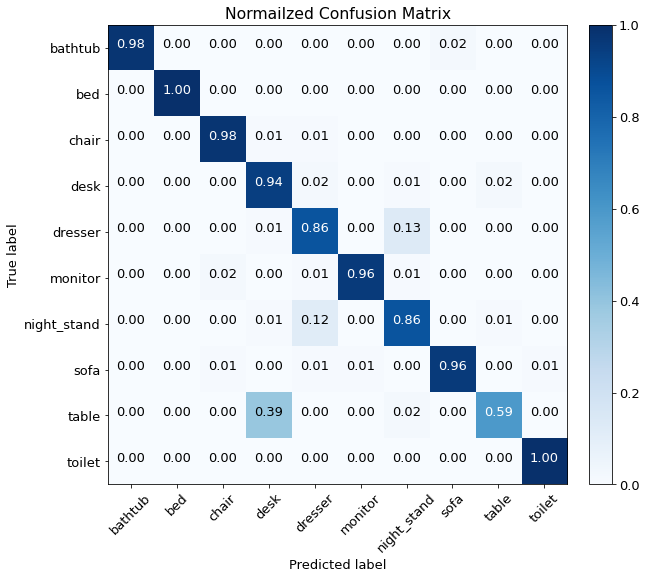

In [56]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Normailzed Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(9,8))
plt.rcParams.update({'font.size': 13})
plot_confusion_matrix(cm, list(train_dataset.classnames), normalize=True)
plt.savefig('mvcnn_cmn.png', dpi=320)

Confusion matrix, without normalization


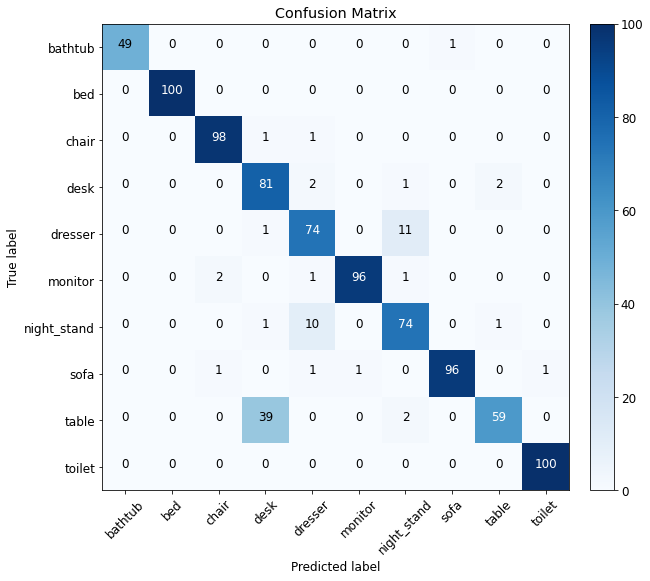

In [55]:
plt.figure(figsize=(9,8))
plt.rcParams.update({'font.size': 12})
plot_confusion_matrix(cm, list(train_dataset.classnames), normalize=False, title="Confusion Matrix")
plt.savefig('mvcnn_cm.png', dpi=300)